In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import struct
import os

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

---
## Загрузка изображения

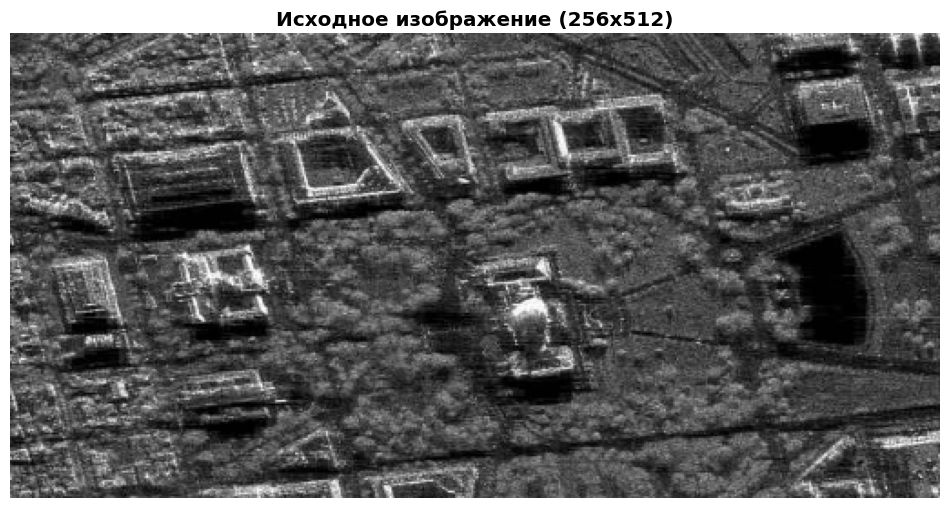

Размер изображения: (256, 512)
Объём памяти (попиксельно): 131072 байт


In [13]:
# Загрузка монохромного изображения
image = cv2.imread('sar_1_gray.jpg', cv2.IMREAD_GRAYSCALE)

# Приводим размер к степени 2 для вейвлет-преобразования
h, w = image.shape
new_h = 2 ** int(np.log2(h))
new_w = 2 ** int(np.log2(w))
image = cv2.resize(image, (new_w, new_h))

plt.imshow(image, cmap='gray')
plt.title(f'Исходное изображение ({image.shape[0]}x{image.shape[1]})', fontweight='bold')
plt.axis('off')
plt.show()

print(f'Размер изображения: {image.shape}')
print(f'Объём памяти (попиксельно): {image.nbytes} байт')

---
## Сохранение в текстовый и бинарный файл

In [14]:
# Сохранение в текстовый файл
def save_to_text(image, filename):
    with open(filename, 'w') as f:
        f.write(f'{image.shape[0]} {image.shape[1]}\n')
        for row in image:
            f.write(' '.join(map(str, row)) + '\n')

# Сохранение в бинарный файл
def save_to_binary(image, filename):
    with open(filename, 'wb') as f:
        f.write(struct.pack('II', image.shape[0], image.shape[1]))
        f.write(image.tobytes())

# Сохраняем
save_to_text(image, 'image_text.txt')
save_to_binary(image, 'image_binary.bin')

# Сравнение размеров
text_size = os.path.getsize('image_text.txt')
binary_size = os.path.getsize('image_binary.bin')

print('Размеры файлов:')
print(f'  Текстовый: {text_size:,} байт')
print(f'  Бинарный:  {binary_size:,} байт')
print(f'  Экономия:  {(1 - binary_size/text_size)*100:.1f}%')

Размеры файлов:
  Текстовый: 417,442 байт
  Бинарный:  131,080 байт
  Экономия:  68.6%


---
## Вейвлет-преобразование Хаара

In [15]:
def haar_wavelet_2d(image):
    """
    2D вейвлет-преобразование Хаара.
    Возвращает: LL, LH, HL, HH
    """
    img = image.astype(np.float64)
    h, w = img.shape
    
    # Преобразование по строкам
    row_L = np.zeros((h, w // 2))
    row_H = np.zeros((h, w // 2))
    
    for i in range(h):
        for j in range(w // 2):
            row_L[i, j] = (img[i, 2*j] + img[i, 2*j + 1]) / 2
            row_H[i, j] = (img[i, 2*j] - img[i, 2*j + 1]) / 2
    
    # Преобразование по столбцам
    LL = np.zeros((h // 2, w // 2))
    LH = np.zeros((h // 2, w // 2))
    HL = np.zeros((h // 2, w // 2))
    HH = np.zeros((h // 2, w // 2))
    
    for j in range(w // 2):
        for i in range(h // 2):
            LL[i, j] = (row_L[2*i, j] + row_L[2*i + 1, j]) / 2
            LH[i, j] = (row_L[2*i, j] - row_L[2*i + 1, j]) / 2
            HL[i, j] = (row_H[2*i, j] + row_H[2*i + 1, j]) / 2
            HH[i, j] = (row_H[2*i, j] - row_H[2*i + 1, j]) / 2
    
    return LL, LH, HL, HH

# Применяем преобразование
LL, LH, HL, HH = haar_wavelet_2d(image)

print(f'Размеры компонент: {LL.shape}')

Размеры компонент: (128, 256)


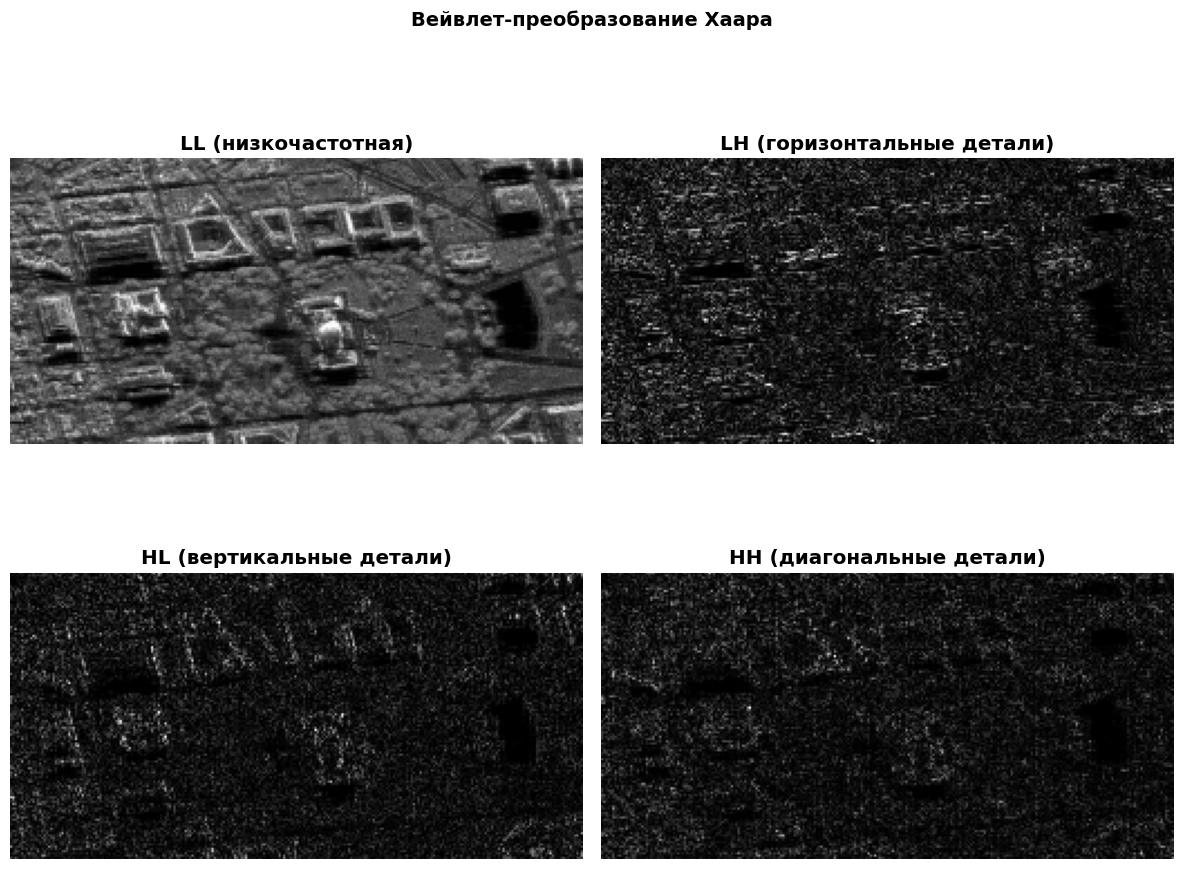

In [16]:
# Визуализация компонент
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].imshow(LL, cmap='gray')
axes[0, 0].set_title('LL (низкочастотная)', fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(np.abs(LH), cmap='gray')
axes[0, 1].set_title('LH (горизонтальные детали)', fontweight='bold')
axes[0, 1].axis('off')

axes[1, 0].imshow(np.abs(HL), cmap='gray')
axes[1, 0].set_title('HL (вертикальные детали)', fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(np.abs(HH), cmap='gray')
axes[1, 1].set_title('HH (диагональные детали)', fontweight='bold')
axes[1, 1].axis('off')

plt.suptitle('Вейвлет-преобразование Хаара', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## Квантование высокочастотных компонент

In [17]:
def quantize(data, num_levels=4):
    """Квантование данных на заданное число уровней."""
    min_val, max_val = data.min(), data.max()
    
    if max_val == min_val:
        return np.zeros_like(data, dtype=np.int8), min_val, max_val
    
    normalized = (data - min_val) / (max_val - min_val)
    quantized = np.floor(normalized * (num_levels - 1) + 0.5).astype(np.int8)
    
    return quantized, min_val, max_val

# Квантование (4 уровня)
num_quants = 4

LH_q, LH_min, LH_max = quantize(LH, num_quants)
HL_q, HL_min, HL_max = quantize(HL, num_quants)
HH_q, HH_min, HH_max = quantize(HH, num_quants)

print(f'Квантование на {num_quants} уровня:')
print(f'  LH: {len(np.unique(LH_q))} уникальных значений')
print(f'  HL: {len(np.unique(HL_q))} уникальных значений')
print(f'  HH: {len(np.unique(HH_q))} уникальных значений')

Квантование на 4 уровня:
  LH: 4 уникальных значений
  HL: 4 уникальных значений
  HH: 4 уникальных значений


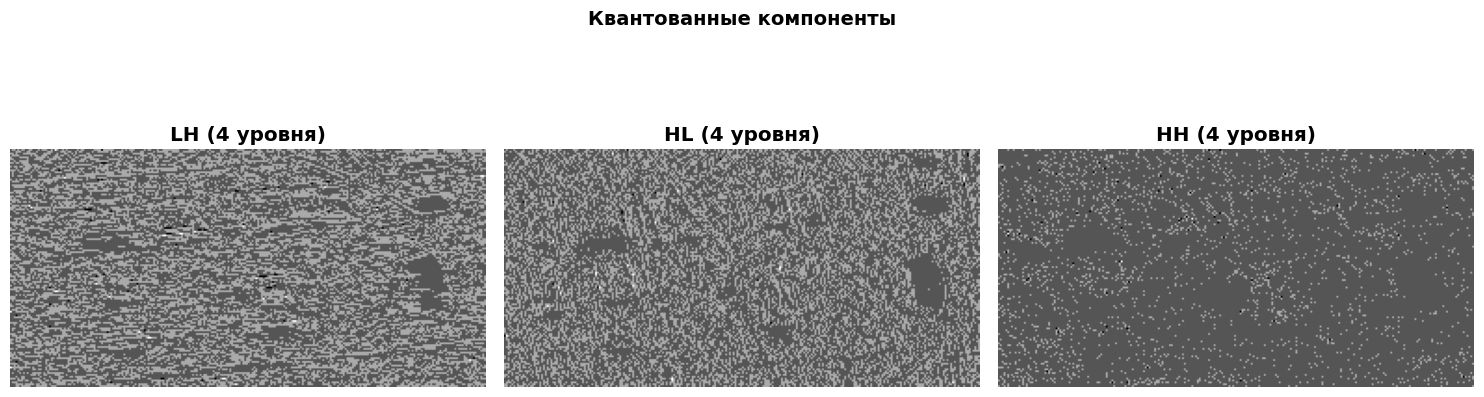

In [18]:
# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(LH_q, cmap='gray')
axes[0].set_title(f'LH ({num_quants} уровня)', fontweight='bold')
axes[0].axis('off')

axes[1].imshow(HL_q, cmap='gray')
axes[1].set_title(f'HL ({num_quants} уровня)', fontweight='bold')
axes[1].axis('off')

axes[2].imshow(HH_q, cmap='gray')
axes[2].set_title(f'HH ({num_quants} уровня)', fontweight='bold')
axes[2].axis('off')

plt.suptitle('Квантованные компоненты', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## RLE-сжатие и сохранение

In [19]:
def rle_encode(data):
    """RLE: возвращает [(значение, кол-во), ...]"""
    flat = data.flatten()
    if len(flat) == 0:
        return []
    
    encoded = []
    current_val = flat[0]
    count = 1
    
    for val in flat[1:]:
        if val == current_val:
            count += 1
        else:
            encoded.append((int(current_val), count))
            current_val = val
            count = 1
    
    encoded.append((int(current_val), count))
    return encoded

# RLE для квантованных компонент
LH_rle = rle_encode(LH_q)
HL_rle = rle_encode(HL_q)
HH_rle = rle_encode(HH_q)

print('RLE-кодирование:')
print(f'  LH: {LH_q.size} пикселей -> {len(LH_rle)} пар ({LH_q.size / len(LH_rle):.1f}x)')
print(f'  HL: {HL_q.size} пикселей -> {len(HL_rle)} пар ({HL_q.size / len(HL_rle):.1f}x)')
print(f'  HH: {HH_q.size} пикселей -> {len(HH_rle)} пар ({HH_q.size / len(HH_rle):.1f}x)')

RLE-кодирование:
  LH: 32768 пикселей -> 11032 пар (3.0x)
  HL: 32768 пикселей -> 16545 пар (2.0x)
  HH: 32768 пикселей -> 4880 пар (6.7x)


In [20]:
def save_wavelet_rle(filename, LL, LH_rle, HL_rle, HH_rle):
    """Сохранение: LL, LH, HL, HH (RLE для высокочастотных)"""
    with open(filename, 'wb') as f:
        # Размеры LL
        h, w = LL.shape
        f.write(struct.pack('II', h, w))
        
        # LL (float32)
        f.write(LL.astype(np.float32).tobytes())
        
        # RLE компоненты
        for rle in [LH_rle, HL_rle, HH_rle]:
            f.write(struct.pack('I', len(rle)))
            for val, cnt in rle:
                f.write(struct.pack('bI', val, cnt))

save_wavelet_rle('wavelet_compressed.bin', LL, LH_rle, HL_rle, HH_rle)
print('Сохранено: wavelet_compressed.bin')

Сохранено: wavelet_compressed.bin


---
## Сравнение объёма памяти

In [21]:
original_size = image.nbytes
text_size = os.path.getsize('image_text.txt')
binary_size = os.path.getsize('image_binary.bin')
wavelet_size = os.path.getsize('wavelet_compressed.bin')

print('=' * 60)
print('СРАВНЕНИЕ ОБЪЁМА ПАМЯТИ')
print('=' * 60)
print(f"{'Формат':<30} {'Размер':<15} {'Сжатие'}")
print('-' * 60)
print(f"{'Исходное (в памяти)':<30} {original_size:>10,} байт   1.00x")
print(f"{'Текстовый файл':<30} {text_size:>10,} байт   {original_size/text_size:.2f}x")
print(f"{'Бинарный файл':<30} {binary_size:>10,} байт   {original_size/binary_size:.2f}x")
print(f"{'Вейвлет + RLE':<30} {wavelet_size:>10,} байт   {original_size/wavelet_size:.2f}x")
print('=' * 60)

СРАВНЕНИЕ ОБЪЁМА ПАМЯТИ
Формат                         Размер          Сжатие
------------------------------------------------------------
Исходное (в памяти)               131,072 байт   1.00x
Текстовый файл                    417,442 байт   0.31x
Бинарный файл                     131,080 байт   1.00x
Вейвлет + RLE                     390,748 байт   0.34x


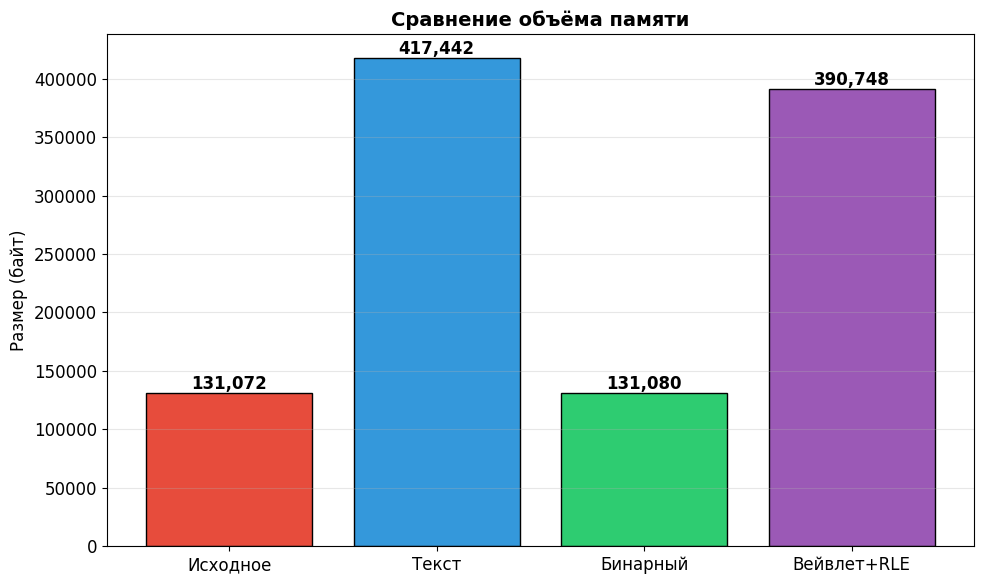

In [22]:
# График
labels = ['Исходное', 'Текст', 'Бинарный', 'Вейвлет+RLE']
sizes = [original_size, text_size, binary_size, wavelet_size]
colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, sizes, color=colors, edgecolor='black')

for bar, size in zip(bars, sizes):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{size:,}', ha='center', va='bottom', fontweight='bold')

plt.ylabel('Размер (байт)')
plt.title('Сравнение объёма памяти', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()